In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mylibrary.nnlib as tnn
import mylibrary.splinelib as tsp

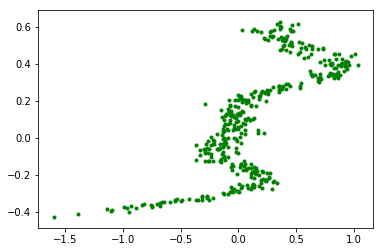

In [2]:
x = np.linspace(0,1,400)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
y = (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
x = x - 0.4 #x.mean() # good practice to zero-center x in linear mapping
sortindx = np.argsort(x)
x = x[sortindx]
y = y[sortindx]
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)
plt.scatter(y, x, marker='.', color='g')

## Using inverse function without optimization(after initialization)

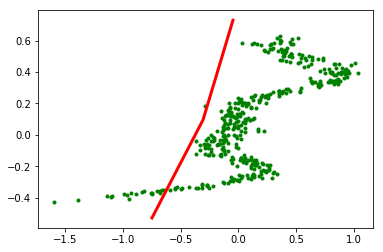

In [3]:
max_points = 3
lr=0.1
spline = tsp.Spline1D(max_points, x, y)
plt.scatter(y, x, marker='.', color='g')
plt.plot(spline.Y, spline.X, color='r', lw=3)

## Reverse Function 

In [4]:
def reverse0(self:tsp.Spline1D, y):
    x = np.zeros_like(self.input)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        x += xpossible*self.rangeX[i]
    return x

### Reverse using the target

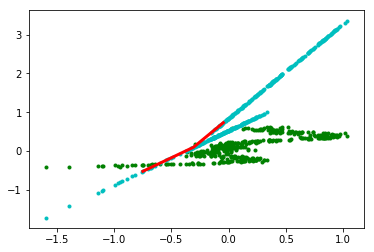

In [5]:
y_ = spline.forward(x)
x_ = reverse0(spline, y)

plt.scatter(y, x, marker='.', color='g')
plt.plot(spline.Y, spline.X, color='r', lw=3)
plt.scatter(y, x_, marker='.', color='c')

#### Gradient of inverse function calculation

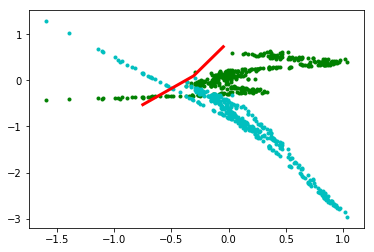

In [6]:
dx_ = x - x_ ## xn = xo - dx
plt.scatter(y, x, marker='.', color='g')
plt.plot(spline.Y, spline.X, color='r', lw=3)
plt.scatter(y, dx_, marker='.', color='c')

## Finding gradients of spline points wrt gradient of inverse function

In [7]:
def _backward_X_(self:tsp.Spline1D, target, del_recons):

    consts = np.zeros((self.n_points-1, target.shape[0]))
    for i in range(self.n_points-1):
        consts[i] = (target-self.Y[i])/self.diffY[i]

    dX = np.zeros((self.n_points, target.shape[0]))

    dX[0] = (-1* consts[0] +1) *self.rangeX[0]
    dX[-1] = consts[-1] *self.rangeX[-1]

    for i in range(1, self.n_points-1):
            a = consts[i-1]*self.rangeX[i-1]
            b = (-1* consts[i] +1)*self.rangeX[i]
            dX[i] = a+b
    dX = dX*del_recons
    ## can choose any three options for gradient of Y
#     dY = dY.sum(axis=1)/self.rangeX_n

    # dY_= dY.sum(axis=1)/self.rangeX_n
    # dY = dY.mean(axis=1)
    # dY[0], dY[-1] = dY_[0], dY_[-1]

    dX = dX.mean(axis=1)

#     self.del_Y = dY
#     return self.del_Y
    return dX

def _backward_Y_(self:tsp.Spline1D, target, del_recons):

    consts = np.zeros((self.n_points-1, target.shape[0]))
    for i in range(self.n_points-1):
        consts[i] = self.diffX[i]/(self.diffY[i]**2)

    dY = np.zeros((self.n_points, target.shape[0]))
    dY[0] = consts[0]*(target - self.Y[1])*self.rangeX[0]
    dY[-1] = -1*consts[-1]*(target - self.Y[-2])*self.rangeX[-1]

    for i in range(1, self.n_points-1):
            a = -1*consts[i-1]*(target - self.Y[i-1])*self.rangeX[i-1]
            b = consts[i]*(target - self.Y[i+1])*self.rangeX[i]
            dY[i] = a+b
    dY = dY*del_recons

    ## can choose any of below options for calculating gradient of X
    dY = dY.mean(axis=1)
    # dX = dX.sum(axis=1)/self.rangeX_n

#     self.del_X = dX
#     return self.del_X
    return dY


def _backward_target_(self:tsp.Spline1D, del_recons):
    dtarg = np.zeros_like(self.output)
    for i in range(self.n_points-1):
        dtarg = dtarg + self.diffX[i]/self.diffY[i] *self.rangeX[i]

    dtarg = dtarg*del_recons
    return dtarg

In [8]:
del_target = _backward_target_(spline, dx_)
del_X_inv = _backward_X_(spline, y, dx_)
del_Y_inv = _backward_Y_(spline, y, dx_)

In [9]:
del_X_inv, del_Y_inv

(array([ 0.23117289,  1.31977979, -2.54225578]),
 array([-0.32535424, -3.70400904,  6.20460911]))

In [10]:
spline.del_X = del_X_inv
spline.del_Y = del_Y_inv

In [11]:
spline.del_X, spline.del_Y

(array([ 0.23117289,  1.31977979, -2.54225578]),
 array([-0.32535424, -3.70400904,  6.20460911]))

In [12]:
spline.update()

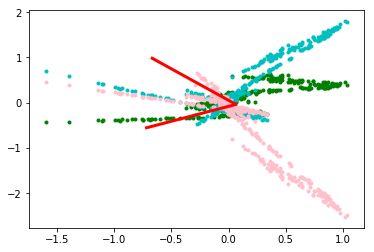

In [13]:
Y = spline.forward(x)
x_ = reverse0(spline, y)
dx_ = x - x_
dy_ = _backward_target_(spline, dx_)

plt.scatter(y, x, marker='.', color='g')
plt.plot(spline.Y, spline.X, color='r', lw=3)
plt.scatter(y, dx_, marker='.', color='c')
plt.scatter(y, dy_, marker='.', color='pink')

## Doing the optimization continuously

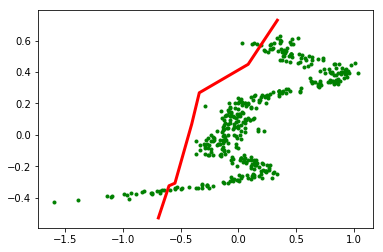

In [20]:
max_points = 7
lr=0.1
spline = tsp.Spline1D(max_points, x, y)
%matplotlib inline
plt.scatter(y, x, marker='.', color='g')
plt.plot(spline.Y, spline.X, color='r', lw=3)

_______________________
Steps 0
ErrorY 7.7201101653271165
ErrorX 1.0717372005858181
Error 8.791847365912934


_______________________
Steps 100
ErrorY 0.0007855040855963574
ErrorX 0.013318490811876322
Error 0.01410399489747268


_______________________
Steps 200
ErrorY 0.0004953133650685525
ErrorX 0.010495978074243168
Error 0.010991291439311721


_______________________
Steps 300
ErrorY 0.00036540966226460765
ErrorX 0.010021779521409035
Error 0.010387189183673644


_______________________
Steps 400
ErrorY 0.00029962798332431613
ErrorX 0.00938440478582398
Error 0.009684032769148296


_______________________
Steps 500
ErrorY 0.00031048145232946564
ErrorX 0.009100382682647934
Error 0.009410864134977399


_______________________
Steps 600
ErrorY 0.0004422643076915641
ErrorX 0.009143646181801737
Error 0.009585910489493301


_______________________
Steps 700
ErrorY 0.0007610152365674162
ErrorX 0.010254173698380204
Error 0.011015188934947621


_______________________
Steps 800
ErrorY 0.001255

TclError: invalid command name "pyimage73"

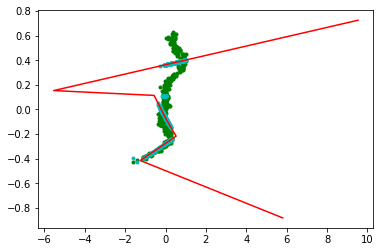

In [21]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for step in range(100000):

    Y = spline.forward(x)
    x_ = reverse0(spline, y)
    dx_ = x_ - x
    
    del_X_inv = _backward_X_(spline, y, dx_)
    del_Y_inv = _backward_Y_(spline, y, dx_)
    dy_ = _backward_target_(spline, dx_)

    
#     dx = spline.backward(dy_)
    
    
#     spline.del_X += del_X_inv
#     spline.del_X/=2
#     spline.del_Y += del_Y_inv
#     spline.del_Y/=2
    
    spline.del_X = del_X_inv
#     spline.del_X = del_X_inv*0.

    spline.del_Y = del_Y_inv
#     spline.del_Y = del_Y_inv*0.
    
    
    spline.update(lr)
    
    ## for integrity of api only
    spline.backward(dy_)
    if step % 1000 == 0:
        spline._remove_close_points_()
        spline._combine_linear_points_()
        spline._remove_no_input_points_()
        spline._add_new_point_()
        
    if step % 100 == 0:            
        errory = (dy_**2).mean()
        errorx = (dx_**2).mean()
        error = errorx+ errory
        print('_______________________')
        print("Steps", step)
        print("ErrorY", errory)
        print("ErrorX", errorx)
        print("Error", error)
        
        ax.clear()
        plt.scatter(y, x, marker='.', color='g')
        plt.plot(spline.Y, spline.X, color='r')
#         plt.scatter(y, dx_, marker='.', color='c')
        plt.scatter(y, x_, marker='.', color='c')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

In [ ]:
plt.scatter(y, x, marker='.', color='g')
plt.plot(spline.Y, spline.X, color='r')
plt.scatter(y, dx_, marker='.', color='c')

In [ ]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, marker='.', color='r')